In [ ]:
"""
Notebook exploring how one might determine the land fraction of each pixel in a netCDF file.
"""

In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import shapely
import xarray as xr

In [2]:
def get_regular_grid_spacing(arr: np.array) -> float:
    """
    Check an array has (almost) equal spacing of its values.
    
    Args:
        arr: Coordinate array to check.
    
    Raises:
        AssertionError if `arr` has unequal spacing of values.
        
    Returns:
        Grid spacing if regular.
    """
    
    difference = np.diff(arr)
    first, *rest = difference
    
    # check spacing is regular
    reference = np.ones_like(rest) * first
    np.testing.assert_almost_equal(reference, rest)
    
    return first

def raster_to_poly_grid(ds: xr.Dataset) -> gpd.GeoDataFrame:
    """
    Given a raster dataset on a regular latitude/longitude grid,
    return a GeoDataFrame of grid cells.
    
    Args:
        ds: Regularly gridded raster dataset
        
    Returns:
        Table with grid cell rows, geometries are cell/pixel boxes
        centered on input coordinates. 
    """
    
    # check our coordinates are present
    assert "longitude" in ds
    assert "latitude" in ds

    # ValueError if more than one grid spacing in each coordinate dimension
    # the rest of this script does not work for irregular grids!
    long_delta: float = get_regular_grid_spacing(ds.longitude)
    lat_delta: float = get_regular_grid_spacing(ds.latitude)

    # create a grid (GeoDataFrame of shapely boxes) from our xarray coordinates
    cells = []
    for x_mid in ds.longitude:
        x0 = x_mid - long_delta / 2
        x1 = x_mid + long_delta / 2
        for y_mid in ds.latitude:
            y0 = y_mid - lat_delta / 2
            y1 = y_mid + lat_delta / 2
            cells.append(shapely.geometry.box(x0, y0, x1, y1))

    return gpd.GeoDataFrame({"geometry": cells}, crs=4326)

In [8]:
# write some sample data as netCDF to disk
# coordinates are decimal degrees (CRS is 4326)
longitude = np.linspace(-20, 5, 20)
latitude = np.linspace(49, 62, 20)
ds = xr.Dataset(
    data_vars = {
        "value": (
            ["longitude", "latitude"],
            np.random.rand(len(longitude), len(latitude))
        )
    },
    coords = {
        "longitude": longitude,
        "latitude": latitude,
    }
)
raster_path = "example_grid.nc"
ds.to_netcdf(raster_path)

# read in our shape to check the grid against
admin_bounds_path = "uk_land.parquet"
vector: gpd.GeoDataFrame = gpd.read_parquet(admin_bounds_path)
    
# output path
land_fraction_path = "land_fraction.nc"


In [11]:
%%time

# read in our sample raster data from netCDF
ds: xr.Dataset = xr.open_dataset(raster_path)

# transform into a GeoDataFrame with rectangular polygon cells
grid: gpd.GeoDataFrame = raster_to_poly_grid(ds)

# calculate the shapes created by the intersection between each cell and the vector
land_cells: gpd.GeoDataFrame = grid.overlay(vector, how="intersection")

# store the area in square degrees, can ignore warnings about CRS
land_cells["land_area"] = land_cells.geometry.area

# merge the (at least partially) land cells back into the total cell list
land_cells.geometry = land_cells.geometry.representative_point()
join = grid.sjoin(land_cells[["land_area", "geometry"]], how="left", predicate="intersects")
join = join.drop(columns=["index_right"])

# NaN land_area -> 0
join.loc[join.loc[:, "land_area"].isna(), "land_area"] = 0

# calculate the land fraction
join["cell_area"] = join.geometry.area
join["land_fraction"] =  join.land_area / join.cell_area

# now revert to xarray, and then back to netCDF
export = join.copy()

# use the cell centroids as the xarray coordinates
export.geometry = export.geometry.centroid
export["longitude"] = export.geometry.x
export.longitude = export.longitude.round(6)
export["latitude"] = export.geometry.y
export.latitude = export.latitude.round(6)

export = export.drop(columns=["land_area", "cell_area", "geometry"])

# check we have the same number of cells we started with
assert len(export) == len(grid) == len(ds.longitude) * len(ds.latitude)

# save our land fraction raster to disk
ds = export.set_index(["longitude", "latitude"]).to_xarray()
ds.to_netcdf(land_fraction_path)

CPU times: user 1.1 s, sys: 7.97 ms, total: 1.11 s
Wall time: 1.1 s


<timed exec>:11: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

<timed exec>:22: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

<timed exec>:29: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



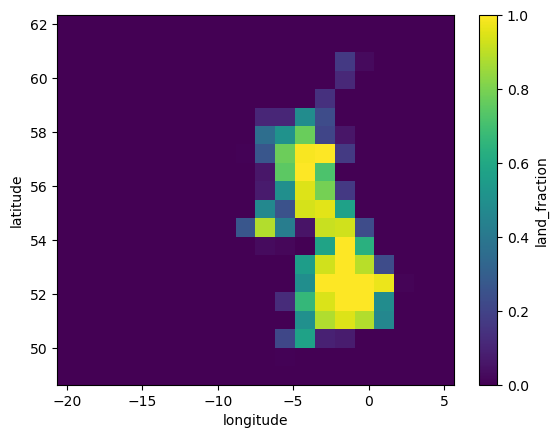

In [5]:
# plot to check out output
xr.plot.pcolormesh(ds.land_fraction, x="longitude")

Text(277.9499392275022, 0.5, 'Latitude [deg]')

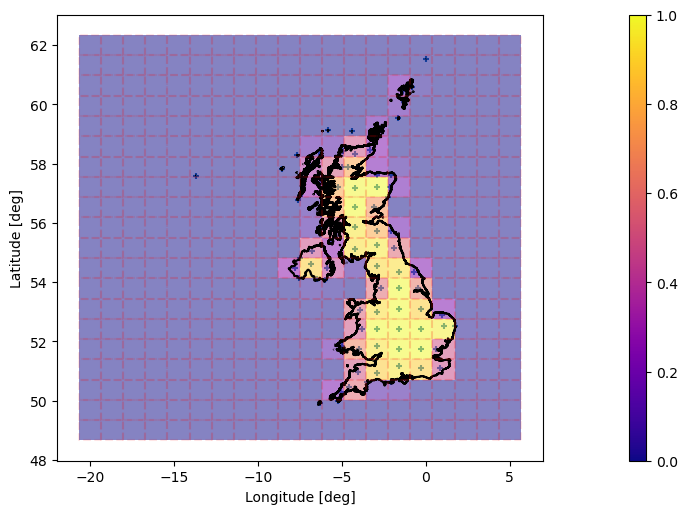

In [6]:
# diagnostic plot to show grid, overlay representative points, etc.
# works best with a relatively coarse grid
f, ax = plt.subplots(figsize=(10, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=-1)

land_cells.plot(ax=ax, markersize=16, marker="+")
join.plot(ax=ax, alpha=0.5, column="land_fraction", legend=True, cax=cax, cmap="plasma")
vector.geometry.boundary.plot(ax=ax, facecolor="none", ls="-", color="black", alpha=1)
grid.geometry.boundary.plot(ax=ax, ls="--", color="red", facecolor="none", alpha=0.1)

ax.set_xlabel("Longitude [deg]")
ax.set_ylabel("Latitude [deg]")